In [1]:
import joblib
import pandas as pd
import soundfile as sf
import glob
from pathlib import Path
from tqdm import tqdm
import numpy as np
import os
from sklearn.metrics import average_precision_score
import copy

os.chdir('/home/lpepino/ast-pe')

In [2]:
class_map = pd.read_csv('../Datasets/Audioset/audioset_class_map.csv')
class_map = class_map.reset_index().set_index('mid')

read_csv_kwarg = {'delimiter': ',',
    'skipinitialspace': True,
    'quotechar': '"',
    'encoding': 'utf-8',
    'header': 2}

df_eval = pd.read_csv('http://storage.googleapis.com/us_audioset/youtube_corpus/v1/csv/eval_segments.csv', **read_csv_kwarg)
df_eval = df_eval.set_index('# YTID')
eval_wavs = glob.glob('../Datasets/audioset_evaluation/*.wav')

In [3]:
def swa(ckpts_to_avg):
    ckpt_swa = {}
    for ckpt_i in ckpts_to_avg:
        ckpt_i = joblib.load(ckpt_i)
        for k,v in ckpt_i.items():
            if k not in ckpt_swa:
                ckpt_swa[k] = copy.deepcopy(v)
            else:
                for i,w in enumerate(v[0]):
                    ckpt_swa[k][0][i] += w

    for k,v in ckpt_swa.items():
        for i,w in enumerate(ckpt_swa[k][0]):
            ckpt_swa[k][0][i] = ckpt_swa[k][0][i]/len(ckpts_to_avg)

    return ckpt_swa

def eval_model(model, ckpt_path=None, average_ckpts=None):
    INPUT_LEN = 158960
    if average_ckpts is not None:
        ckpt_metadata = joblib.load(Path(ckpt_path,'metadata'))
        ckpt_metadata = {m['step']: m['weights_path'] for m in ckpt_metadata}
        ckpts = list(ckpt_metadata.values())
        to_avg_ckpts = ckpts[-average_ckpts:]
        print('SWA of {}/{} checkpoints'.format(len(to_avg_ckpts),len(ckpts)))
        print(list(ckpt_metadata.keys()))
        swa_ckpt = swa(to_avg_ckpts)
        model.set_weights(swa_ckpt)

    preds = []
    gts = []
    filenames = []
    xs = []
    BATCH_SIZE = 64
    for x in tqdm(eval_wavs):
        gt = np.zeros((len(class_map),))
        for l in df_eval.loc[str(Path(x).stem)]['positive_labels'].split(','):
            gt[class_map.loc[l]['index']] = 1
        gts.append(gt)
        x, fs = sf.read(x)
        filenames.append(x)
        if x.ndim>1:
            x = np.mean(x,axis=1)
        if len(x) < INPUT_LEN:
            x = np.pad(x,(0,INPUT_LEN - x.shape[0]))
        else:
            x = x[:INPUT_LEN]
        xs.append(x)
        if len(xs) == BATCH_SIZE:
            pred = model.predict(np.array(xs))
            preds.append(pred)
            xs = []
    if len(xs) > 0:
        pred = model.predict(np.array(xs))
        preds.append(pred)

    preds = np.concatenate(preds)
    gts = np.stack(gts)
    
    ap = average_precision_score(gts,preds,average=None)
    mAP = np.mean(ap)

    return mAP

In [6]:
ABS_CKPT_PATH = 'cache/29ee2dbd2ca67d07ea6bdc598b0a17352309a770/checkpoints'
PEG_CKPT_PATH = 'cache/d62760c2ef31d621ca8ae8f656e3ca61e590c42a/checkpoints'
PEG_PLUS_ABS_CKPT_PATH = 'cache/0f0b64844ee142b4e284e69f985b19000ec95e63/checkpoints'

#abs_model = joblib.load('pretrained_models/abs-pe-encodings-220ksteps.dnn')
#peg_model = joblib.load('pretrained_models/peg-embeddings-220ksteps.dnn')
peg_plus_abs_model = joblib.load('pretrained_models/peg-plus-abs.dnn')

def make_dnn_model_swa(model, ckpt_path, output_path, n_checkpoints=25):
    ckpt_metadata = joblib.load(Path(ckpt_path,'metadata'))
    ckpt_metadata = {m['step']: m['weights_path'] for m in ckpt_metadata}
    ckpts = list(ckpt_metadata.values())
    to_avg_ckpts = ckpts[-n_checkpoints:]
    print('SWA of {}/{} checkpoints'.format(len(to_avg_ckpts),len(ckpts)))
    print(list(ckpt_metadata.keys()))
    swa_ckpt = swa(to_avg_ckpts)
    model.set_weights(swa_ckpt)
    joblib.dump(model, output_path)

#make_dnn_model_swa(abs_model, ABS_CKPT_PATH, 'pretrained_models/abs-pe-encoding-swa.dnn', 25)
#make_dnn_model_swa(peg_model, PEG_CKPT_PATH, 'pretrained_models/peg-embeddings-swa.dnn', 25)
make_dnn_model_swa(peg_plus_abs_model, PEG_PLUS_ABS_CKPT_PATH, 'pretrained_models/peg-plus-abs-swa.dnn', 25)


SWA of 25/29 checkpoints
[9999, 19999, 29999, 39999, 49999, 59999, 69999, 79999, 89999, 99999, 109999, 119999, 129999, 139999, 149999, 159999, 169999, 179999, 189999, 199999, 209999, 219999, 229999, 239999, 249999, 259999, 269999, 279999, 289999]


In [7]:
#model = joblib.load('pretrained_models/abs-pe-encodings-220ksteps.dnn')
#abs_best_ckpt_map = eval_model(model)
#print(abs_best_ckpt_map)
#model = joblib.load('pretrained_models/peg-embeddings-220ksteps.dnn')
#peg_best_ckpt_map = eval_model(model)

#model = joblib.load('pretrained_models/peg-embeddings-balancedmixup-250ksteps.dnn')
#peg_mixup_map = eval_model(model)
#print(peg_mixup_map)
#swa_maps = [eval_model(model,
#            'cache/29ee2dbd2ca67d07ea6bdc598b0a17352309a770/checkpoints',
#            i) for i in range(37)]

model = joblib.load('pretrained_models/peg-plus-abs.dnn')
peg_plus_abs_best_ckpt_map = eval_model(model)
print('PEG_plus_abs: {:.3f}'.format(peg_plus_abs_best_ckpt_map))
model = joblib.load('pretrained_models/peg-plus-abs-swa.dnn')
peg_plus_abs_swa_map = eval_model(model)
print('PEG_plus_abs_swa: {:.3f}'.format(peg_plus_abs_swa_map))

100%|██████████| 16710/16710 [01:50<00:00, 150.73it/s]


PEG_plus_abs: 0.321


/home/lpepino/repos/dienen/src/dienen/core/model.py:72: UserWarning: Failed setting GPUs. Visible devices cannot be modified after being initialized
  warnings.warn('Failed setting GPUs. {}'.format(e))
100%|██████████| 16710/16710 [01:42<00:00, 163.56it/s]


PEG_plus_abs_swa: 0.331


In [7]:
abs_swa_map = joblib.load('pretrained_models/swa_maps_abs.jl')[25]
peg_swa_map = joblib.load('pretrained_models/swa_maps_peg.jl')[25]

In [9]:
abs_swa_map

NameError: name 'abs_swa_map' is not defined

In [8]:
print('Abs best checkpoint MAP: {:.3f}'.format(abs_best_ckpt_map))
print('Abs SWA MAP: {:.3f}'.format(abs_swa_map))
print('CPEG best checkpoint MAP: {:.3f}'.format(peg_best_ckpt_map))
print('CPEG SWA MAP: {:.3f}'.format(peg_swa_map))

Abs best checkpoint MAP: 0.288
Abs SWA MAP: 0.315
CPEG best checkpoint MAP: 0.321
CPEG SWA MAP: 0.345


In [6]:
joblib.dump(swa_maps,'pretrained_models/swa_maps_abs.jl')

['pretrained_models/swa_maps_abs.jl']

In [5]:
swa_maps = joblib.load('pretrained_models/swa_maps_abs.jl')

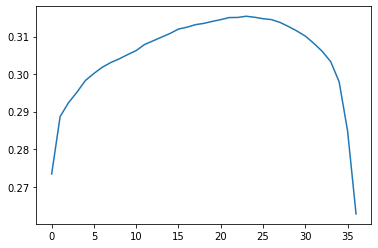

In [7]:
import matplotlib.pyplot as plt

plt.plot(swa_maps)

Text(0, 0.5, 'mAP')

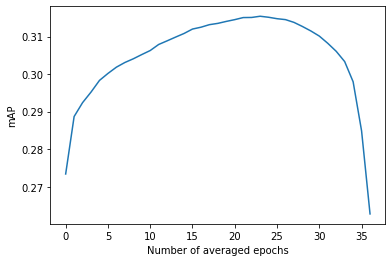

In [5]:
import matplotlib.pyplot as plt

swa_maps.append(swa_maps[0])
swa_maps = swa_maps[1:]

plt.plot(swa_maps)
plt.xlabel('Number of averaged epochs')
plt.ylabel('mAP')